In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
base_path = '/content/drive/My Drive/ai-school/DeepLearning/'

# 신경스타일 전이

## A Neural Algorithm of Artistic Style

사진을 특정 명화 스타일 이미지로 변경

**텍스처(Texture)**는 

넓은 의미로는 단순히 이미지를 의미로는

지역적으로는 비교적 다양한 값을 가지면서, 전체적으로는 비슷한 모습을 보이는 이미지를

ex) 타일, 나무, 구름, 옷의 섬유 등의 텍스처에서는 이러한 일정한 패턴을 관찰
(이 패턴은 전체적으로는 비슷하면서 지역적으로는 조금씩 다름)

**텍스처 합성**은 

한장의 이미지를 원본으로 삼아 다른 해당 텍스처를 합성하는 작업

- 합성되는 이미지는 원본과 비슷해야 하면서도 너무 똑같으면 안됨

- 어색한 부분과 반복적인 부분이 없어야 함

- 원하는 크기로 생성가능

1. 
픽셀이나 이미지를 작게 쪼갠 단위인 패치(patch)를 재배열하는 방법

실제 포토샵에 Content-Aqare-Fill 기능

2. 
파라미터에 의한 텍스처 모델링 기법

**딥러닝의 장점**

다수의 필터를 사람이 직접 정교하게 만드는 것 보다 컨볼루션 신경망이 더 뛰어나게 자동으로 만들어서 신경망이 이미지의 특징을 자동으로 추출할 수 있도록 설정

이러한 특징 추출값을 종합하면 앞서 이야기한 이미지의 '공간적 통계값'을 뽑아낼 수 있게 된다.

이를 위해서는 각 레이어의 특징 추출값에서 'Gram matrix'라는 값을 계산

**Gram matrix**는 각 뉴런의 특징 추출값을 1차원 벡터로 변환한 다음에 벡터를 쌓아 올린 행렬을 준비

다시 그 행렬을 전치한 '전치 행렬'과 행렬곲을 해서 얻어내는 값

- 원본 텍스처와 타겟 텍스처의 gram matrix를 모두 구한다음, 두 gram matrix의 MSE 구하기

- 이 오차가 작아지도록 타깃 텍스처를 변형, 즉 학습을 수행하게 되면 원본 텍스처를 닮은 타깃 텍스쳐 생성

## 1.1 신경스타일 전이

### 원본 텍스처 이미지 불러오기 및 픽셀 정규화

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import cv2

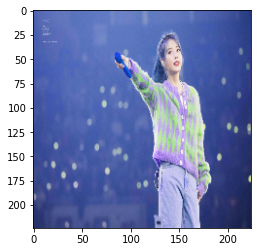

In [5]:
style_image = plt.imread(base_path + 'origin_img.jpg')
# plt.imshow(style_image)

style_image = cv2.resize(style_image, dsize=(224, 224))
style_image = style_image / 255.0

plt.imshow(style_image)

### 타겟 텍스처 생성

- 위에서 불러온 이미지와 같은 차원을 갖는 랜덤 노이즈 생성

- dsize: (224, 224, 3)

- tf.random.uniform(): 균등분포로 부터 난수값을 변환, 즉 모든 픽셀에 대하여 0 ~ 1 사이의 난수값을 반환

tf.Tensor([0.6949153  0.33334327 0.27260828], shape=(3,), dtype=float32)


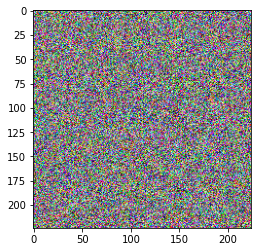

In [6]:
target_image = tf.random.uniform(style_image.shape)

# 부분 확인(타겟 텍스처의 첫 번째 픽셀(0, 0)의 값 출력)
print(target_image[0, 0, :])
plt.imshow(target_image)

### 특징 추출기 VGG19 불러오기

- include_top: 전체 신경망을 불러올 필요없음. 마지막 Dense 레이어 제외한 나머지 레이어를 불러옴

- weights: 가중치가 학습된 데이터세트

In [7]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [8]:
# vgg에 속에 있는 레이어 확인(마지막 dense 레이어는 불러오지 않음)
vgg = VGG19(include_top=False, weights='imagenet')

# 각 레이어의 이름 확인
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Gram_matrix 수행 사전준비

In [9]:
# Gram matrix를 수행하기 위해 각 block마다의 첫 번째 conv1를 출력으로 하는 새로운 모델을 만든다.
# 네트워크 전체로 볼 때, 다섯개의 컨볼루션 레이어를 고르게 선택 및 이름 저장
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# VGG19 layers freeze
vgg.trainable = False

# 각 블럭마다의 첫번째 conv1를 빼내 출력으로 하는 새로운 모델 생성 준비
outputs = [vgg.get_layer(name).output for name in style_layers]

print(outputs)

# 모델 생성
# 이미지를 입력하면 다섯개의 레이어에서 출력되는 특징 추출값을 얻을 수 있는 모델
model = tf.keras.Model([vgg.input], outputs)

[<tf.Tensor 'block1_conv1/Relu:0' shape=(None, None, None, 64) dtype=float32>, <tf.Tensor 'block2_conv1/Relu:0' shape=(None, None, None, 128) dtype=float32>, <tf.Tensor 'block3_conv1/Relu:0' shape=(None, None, None, 256) dtype=float32>, <tf.Tensor 'block4_conv1/Relu:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block5_conv1/Relu:0' shape=(None, None, None, 512) dtype=float32>]


In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

### Gram_matrix 수행 함수 제작

In [11]:
def gram_matrix(input_tensor):
  # [1, 224, 224, 64] 중 64 즉, 채널값 저장
  channels = int(input_tensor.shape[-1])

  # tensor를 받아서, 채널 제외, 1차원 벡터로 변환
  # [224, 224, 64] --> [50176, 64]    # 224*224=50176
  # [-1, 64] 중 -1의 역할은 고정된 차원을 생성 즉 마지막에 64 차원(채널) 생성
  a = tf.reshape(input_tensor, [-1, channels])
  
  # a의 첫 번째 차원값을 저장
  # n = 50176
  n = tf.shape(a)[0]

  # 행렬곱 수행 (a, a, transpose_a = true (a를 전치행렬) )
  # [64, 50176]*[50176, 64] = [64, 64]
  gram = tf.matmul(a, a, transpose_a=True)

  # 일종의 정규화(하지 않게되면 앞쪽에 오는 레이어일수록 특징 추출값의 이미지가 크기 때문에 Gram_matrix 값도 커지게 되므로 큰 영향을 주게됨)
  # tf.cast() 타입 변화

  return gram / tf.cast(n, tf.float32)

### 원본 텍스처 준비

In [12]:
# 맨처음 한 style_image 불러오기 및 픽셀 정규화
style_image

# 배치 차원 생성 (224, 224, 3) --> (1, 224, 224, 3)
# 신경망 입력 조건
style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis=0)

# model
# preprocess_input(): 이미지 전처리 함수, 0 ~ 255의 픽셀값이 들어온다는 가정
# preprocess_input() : VGG-19에서 이미지를 전처리 해주는 함수, mode = 'caffe'
# 이미지 배치를 인코딩하는 텐서 또는 Numpy 배열 사전 처리. 
# 이미지를 RGB에서 BGR로 변환 한 다음 스케일링없이 ImageNet 데이터 세트와 관련하여 각 색상 채널의 중심을 제로화합니다.
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/imagenet_utils/preprocess_input?hl=ko-KR 

'''@keras_export('keras.applications.vgg19.preprocess_input')
def preprocess_input(x, data_format=None):
  return imagenet_utils.preprocess_input(
      x, data_format=data_format, mode='caffe')'''

# style_output은 다섯 레이어를 통과한 특징 추출값으로 구성 
# 0~255의 픽셀값이 들어온다는 가정했기에 값에 255.0을 곱해준다.
# 앞서 설정한 model에 원본 이미지 넣어주기 
style_output = model(preprocess_input(style_batch*255.0))

### 원본 텍스처의 첫 번째 특징 추출값 확인 (style_output)

(1, 224, 224, 64)


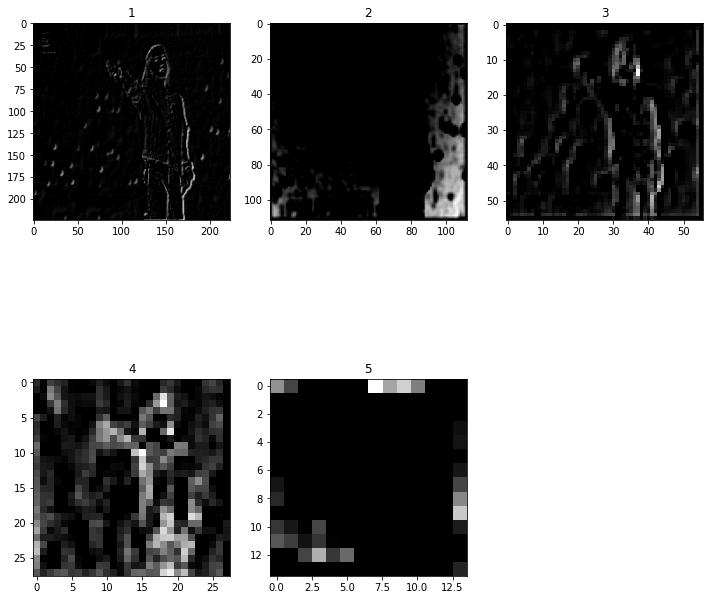

In [44]:
print(style_output[0].shape)

# 시각화를 하려면 2차원으로 맞춰야 하기 때문에 tf.squeeze()를 사용, axis=0을 적용하여 맨 앞의 1차원 제거
# (1, 224, 224) --> (224, 224)
plt.figure(figsize=(12, 12))
for i in range(5):
  plt.subplot(2, 3, i+1)
  plt.imshow(tf.squeeze(style_output[i][:, :, :, 0], axis=0), cmap='gray')
  plt.title(f"{i+1}")

plt.show()

### tf.squeeze() 적용 전과 후 차이

In [40]:
print(tf.squeeze(style_output[0][:,:,:,0],axis = 0))

tf.Tensor(
[[  0.          0.          0.        ...  96.391045   95.608376
    0.       ]
 [  0.          0.          0.        ...   9.579574    4.7344627
    0.       ]
 [  0.          0.          6.5646906 ...   7.296034    4.2799463
    0.       ]
 ...
 [105.2935      6.2023654   1.8229406 ...   9.079049    7.8691816
    0.       ]
 [101.65091     2.8861797   2.9327126 ...  13.697745   12.137878
    0.       ]
 [  0.          0.          0.        ...   0.          0.
    0.       ]], shape=(224, 224), dtype=float32)


In [41]:
print(style_output[0][:, :, :, 0])

tf.Tensor(
[[[  0.          0.          0.        ...  96.391045   95.608376
     0.       ]
  [  0.          0.          0.        ...   9.579574    4.7344627
     0.       ]
  [  0.          0.          6.5646906 ...   7.296034    4.2799463
     0.       ]
  ...
  [105.2935      6.2023654   1.8229406 ...   9.079049    7.8691816
     0.       ]
  [101.65091     2.8861797   2.9327126 ...  13.697745   12.137878
     0.       ]
  [  0.          0.          0.        ...   0.          0.
     0.       ]]], shape=(1, 224, 224), dtype=float32)


### Gram_matrix 수행 결과값들의 분포 


- 현재 Gram matrix 값은 **레이어마다 다르고 최댓값도 차이가 크게 남**

- 각 레이어에서 계산되는 **Gram matrix값에 가중치를 곱해주는 방법**으로 특정한 레이어가 너무 큰 영향을 끼치지 못하도록 제어도 가능하지만 **우선 그냥 수행**

In [14]:
import numpy as np 

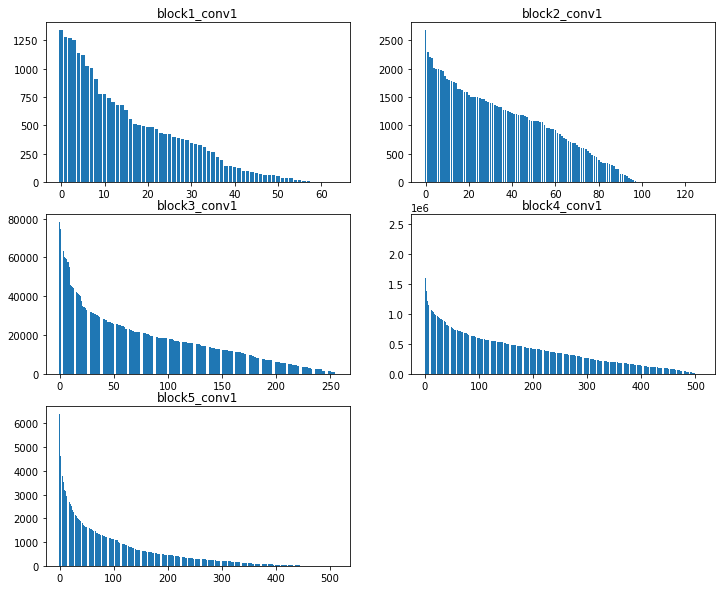

In [15]:
# 각 블럭마다의 conv1을 Gram_matrix()에 적용
style_outputs = [gram_matrix(out) for out in style_output]

plt.figure(figsize=(12, 10))

for c in range(5):
    plt.subplot(3, 2, c+1)

    # Gram_matrix 값을 도출하여 리스트 형태로 만들어 정렬

    array = sorted(style_outputs[c].numpy()[0].tolist())

    # 내림차순
    array = array[::-1]

    # bar 출력
    plt.bar(range(style_outputs[c].shape[0]), array)

    # style_layers에 저장된 이름들 순차적 출력
    plt.title(style_layers[c])

plt.show()

### 타겟 텍스처에서 Gram matrix 구하는 함수

In [16]:
def get_outputs(image):
    # 배치 차원 추가
    image_batch = tf.expand_dims(image, axis=0)

    # 각 값에 255를 곱해주고, preprocess_input을 통한 전처리 후 model에 할당
    output = model(preprocess_input(image_batch * 255.0))

    # 모델 통과 후 Gram_matrix 값 도출
    outputs = [gram_matrix(out) for out in output]

    return outputs

### 타겟 텍스처와 원본 텍스처의 Gram_matrix 갑셍 대한 MSE 도출

- tf.reduce_mean(): 전체 평균을 구하되, 모든 차원을 제거하고 단 하나의 차원(스칼라)만을 반환한다.

In [17]:
def get_loss(outputs, style_outputs):
    return tf.reduce_mean([tf.reduce_mean((o-s)**2) for o, s in zip(outputs, style_outputs)])

### 이미지 픽셀 컬러값 0 ~ 1 값 고정

- tf.clip_by_value(): 최소값과 최대값을 정해 넘어가는 값을 잘라주는 함수

In [18]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

### tf.function과 GradientTape을 활용한 이미지 업데이트 함수 정의

- @장식자(decorator) 활용: 기존의 코드에 간편하게 기능을 추가설명_1.ipynb

- tf.function(): 성능을 올려주는 새로운 함수

    - 참고: https://www.tensorflow.org/guide/function?hl=ko

tf.function()으로 성능 향상하기

### GradientTape

- 계산에 관계되는 모든 변수와 연산을 추적

- 보통 with()과 함께 사용

In [19]:
# 경사하강법 최적화 수행 Adam
opt = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)

# decorator 활용
@tf.function()

def train_step(image):
    # 보통 GradientTape()은 with와 함께 사용
    with tf.GradientTape() as tape:
        # Gram_matrix 결과 출력
        outputs = get_outputs(image)

        # 원본과 타겟 텍스처간의 loss(mse) 산출
        loss = get_loss(outputs, style_outputs)

    # 역전파 과정
    # tape의 gradient()를 사용하여 입력값과 손실사이의 손실 기울기를 구해준다.
    grad = tape.gradient(loss, image)

    # grid에 옵티마이저를 적용한 학습을 통해 image를 개선시킨다. 
    opt.apply_gradients([(grad, image)])

    # 개선된 image를 마지막으로 clip 함수를 적용시켜 새로운 image를 생성(assign)
    image.assign(clip_0_1(image))

### 학습 수행

In [20]:
import IPython.display as display   # 이전 텍스처를 지우고 새로운 텍스처 생성
import time     # 실행시간 추적
import imageio      # 합성된 텍스처 저장

In [21]:
# 현재 시간을 담아준다
start = time.time()

# 텐서플로의 그래프 연산을 위한 변수화
image = tf.Variable(target_image)

# 에폭수
epochs = 50

# 한번의 에폭을 위한 누적 에폭수
steps_per_epoch = 100

# 스탭 수
step = 0

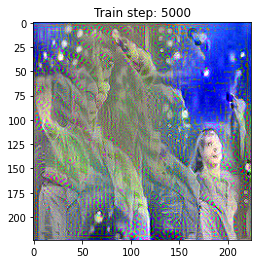

100%|██████████| 50/50 [04:24<00:00,  5.28s/it]

Total time: 264.2


In [22]:
from tqdm import tqdm

# 에폭 수 만큼 반복
for n in tqdm(range(epochs)):
    # 한번의 에폭을 수행하기 위한 누적 에폭수 반복
    for m in range(steps_per_epoch):
        step += 1
        # train_step() 함수를 실행하여 타겟 텍스쳐(image)를 학습
        train_step(image)

    # 저장해주는 조건식(0 부터 5단위 혹은 49번째)
    if n % 5 == 0 or n == epochs-1:
        # 저장해주기 / '파일명.png'
        imageio.imwrite(base_path + f'style_img/style_epoch_{n}.png', image.read_value().numpy())

    # 100번의 에폭이 끝나면 지워준다.
    display.clear_output(wait=True)

    # 다음 100번째의 이미지 출력
    plt.imshow(image.read_value())

    # train step 출력
    plt.title(f"Train step: {step}")
    plt.show()

# 끝나는 시간 기록
end = time.time()

# end - start(걸린 시간) 출력
print(f"Total time: {end - start:.1f}")


# Variation loss 함수 정의

- 앞서 출력한 결과는 자글자글한 노이즈가 포함되어 있다. (개선 필요)

- 일반적인 전체 손실에 variation loss를 추가할 수 있다.

  - variation loss: 어떤 픽셀과 바로 옆에 인접한 픽셀의 차이

    이 차이가 작을 수록 매끄럽게 보인다.